In [5]:
import subprocess, os
import polars as pl
import pandas as pd
import numpy as _np
from plotnine import *
import yfinance as yf
from pathlib import Path

pl.Config.set_tbl_rows(10000)  # or a large enough number for your table
pl.Config.set_tbl_width_chars(200)  # widen output if needed
pl.Config.set_tbl_cols(100)  # show all columns

# ROOT = os.path.join(os.getcwd(), "data")
# events = pl.read_parquet(
#     os.path.join(ROOT, "ntbs/processed.parquet"),
# )


polars.config.Config

In [6]:
# INJURY_COUNT_THRESH = 100
# events = events.filter(pl.col("inj_all_tot") > INJURY_COUNT_THRESH)
# reduced_events = events.select(
#     pl.col(["acft_make", "oper_name", "ev_date", "inj_all_tot"])
# ).sort("inj_all_tot", descending=True)
# reduced_events

# # map operator/manufacturer → ticker YOU want to analyze
# AIRLINE_TICKERS = {
#     "Air France": "AF.PA",
#     # add more if you want: "American Airlines": "AAL", "Delta Air Lines": "DAL", ...
# }
# OEM_TICKERS = {"BOEING": "BA", "AIRBUS": "EADSY"}  # or "AIR.PA" for Airbus

# # choose one set to start (airlines OR OEMs). You can run both.
# ANALYZE_TICKERS = list(AIRLINE_TICKERS.values()) + list(OEM_TICKERS.values())


In [7]:
# pip install requests pandas
import requests, pandas as pd

# REQUIRED: SEC wants a real User-Agent (your name + email or site)
UA = {"User-Agent": "your_name your_email"}

# Map your US tickers to CIKs (add more if needed)
CIK = {
    "BA": 12927,  # Boeing
    "LUV": 92380,  # Southwest
}
ROOT = "/home/jovyan/Documents/10_fall2025/courses/MGTA452/project/data/financials/"

# For each "metric", give candidate us-gaap concept names (try in order; pick longest series)
CONCEPTS = {
    "revenue": [
        "RevenueFromContractWithCustomerExcludingAssessedTax",
        "SalesRevenueNet",
        "Revenues",
    ],
    "oper_income": [
        "OperatingIncomeLoss",
        "IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest",
    ],
    "net_income": [
        "NetIncomeLoss",
        "ProfitLoss",
    ],
    "interest_expense": [
        "InterestExpense",
        "InterestExpenseDebt",
    ],
    "total_assets": [
        "Assets",
    ],
    "total_liabilities": [
        "Liabilities",
    ],
    "long_term_debt": [
        "LongTermDebtNoncurrent",
        "LongTermDebt",
    ],
    "short_term_debt": [
        "ShortTermBorrowings",
        "DebtCurrent",
        "ShortTermDebt",
    ],
    "cash_and_equiv": [
        "CashAndCashEquivalentsAtCarryingValue",
        "CashCashEquivalentsAndShortTermInvestments",  # fallback if first is missing
    ],
    "cfo": [
        "NetCashProvidedByUsedInOperatingActivities",
        "NetCashProvidedByUsedInOperatingActivitiesContinuingOperations",
    ],
    "capex": [
        "PaymentsToAcquirePropertyPlantAndEquipment",
        "CapitalExpendituresIncurredButNotYetPaid",
        "CapitalExpenditures",
    ],
}


def sec_company_concept(cik: int, concept: str) -> pd.DataFrame:
    url = f"https://data.sec.gov/api/xbrl/companyconcept/CIK{cik:010d}/us-gaap/{concept}.json"
    r = requests.get(url, headers=UA, timeout=30)
    if not r.ok:
        return pd.DataFrame()
    j = r.json()
    rows = []
    for unit, vals in (j.get("units") or {}).items():
        for v in vals:
            # keep quarterly facts
            if v.get("fp") in {"Q1", "Q2", "Q3", "Q4"} and v.get("end"):
                rows.append(
                    {
                        "period_end": v["end"],
                        "value": v.get("val"),
                        "unit": unit,
                        "filed": v.get("filed"),
                        "fy": v.get("fy"),
                        "fp": v.get("fp"),
                        "form": v.get("form"),
                        "concept": concept,
                    }
                )
    df = pd.DataFrame(rows)
    if df.empty:
        return df
    df["period_end"] = pd.to_datetime(df["period_end"])
    # keep the latest filed value per period_end
    df = df.sort_values(["period_end", "filed"]).drop_duplicates(
        "period_end", keep="last"
    )
    return df[["period_end", "value"]]


def pick_best_series(cik: int, concept_list: list) -> pd.DataFrame:
    series = []
    for c in concept_list:
        df = sec_company_concept(cik, c)
        if not df.empty:
            series.append(df.assign(_concept=c))
    if not series:
        return pd.DataFrame()
    # choose the concept with the longest series; tie-breaker = latest last date
    best = max(series, key=lambda d: (len(d), d["period_end"].max()))
    return best.drop(columns=["_concept"])


def sec_quarterlies(ticker: str) -> pd.DataFrame:
    cik = CIK[ticker]
    out = None
    for metric, concept_list in CONCEPTS.items():
        df = pick_best_series(cik, concept_list)
        if df.empty:
            continue
        df = df.rename(columns={"value": metric})
        out = df if out is None else out.merge(df, on="period_end", how="outer")
    if out is None or out.empty:
        return pd.DataFrame()
    out = out.sort_values("period_end")
    # derived metrics
    if {"cfo", "capex"}.issubset(out.columns):
        out["fcf"] = out["cfo"] - out["capex"]
    # net debt = (short + long) - cash
    if {"long_term_debt", "short_term_debt", "cash_and_equiv"}.issubset(out.columns):
        out["net_debt"] = (
            out["long_term_debt"].fillna(0)
            + out["short_term_debt"].fillna(0)
            - out["cash_and_equiv"].fillna(0)
        )
    return out[out["period_end"] >= "2008-01-01"].reset_index(drop=True)


# # === EXAMPLES ===
# ba_q = sec_quarterlies("BA")
# luv_q = sec_quarterlies("LUV")
# path = (
#     lambda s: f"/home/jovyan/Documents/10_fall2025/courses/MGTA452/project/data/financials/{s}.parquet"
# )
# ba_q.to_parquet(path("ba_q"))
# luv_q.to_parquet(path("luv_q"))


/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 30 rows containing missing values.
/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 41 rows containing missing values.


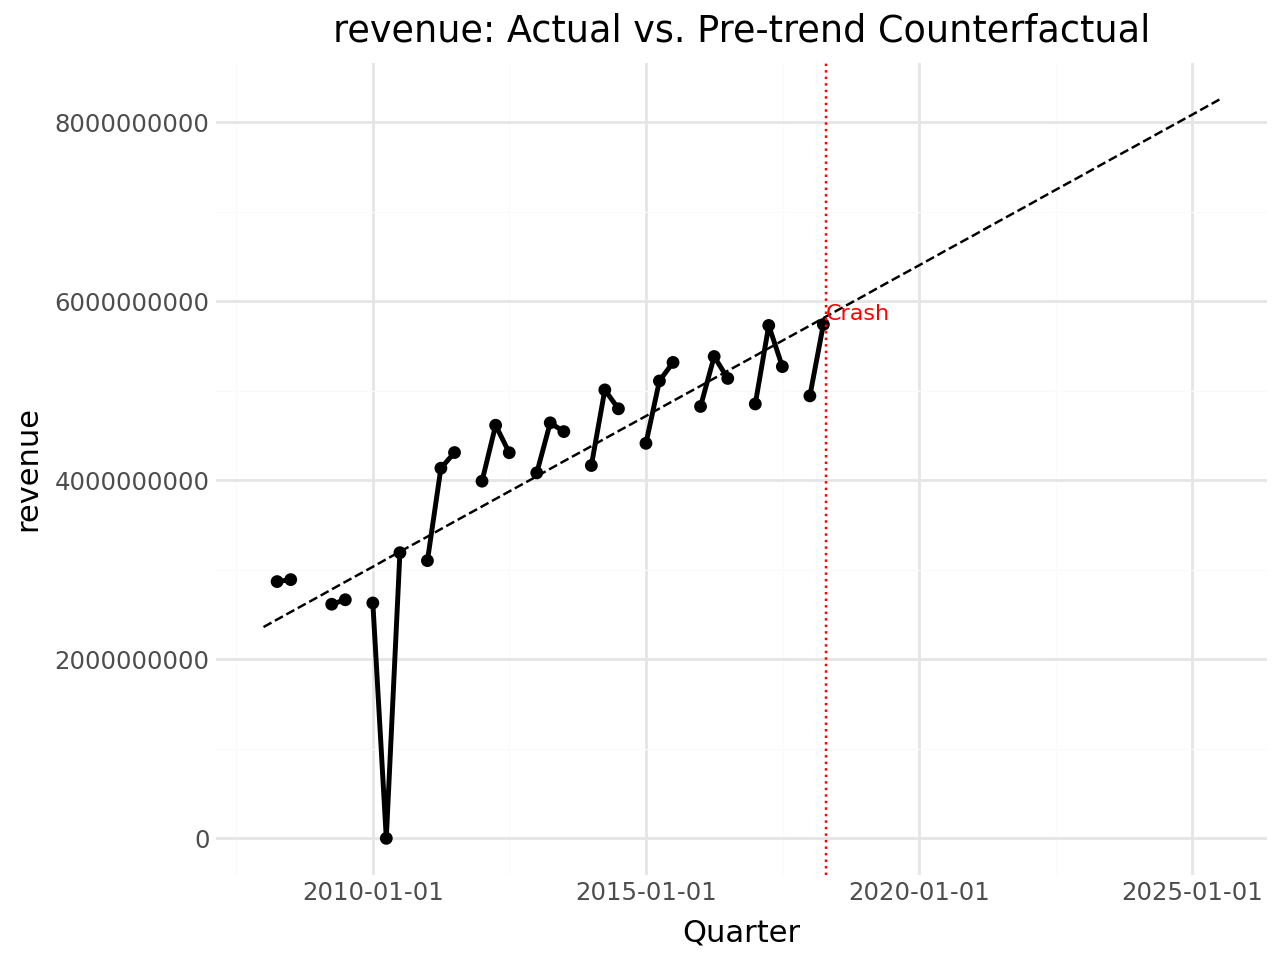

/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 19 rows containing missing values.


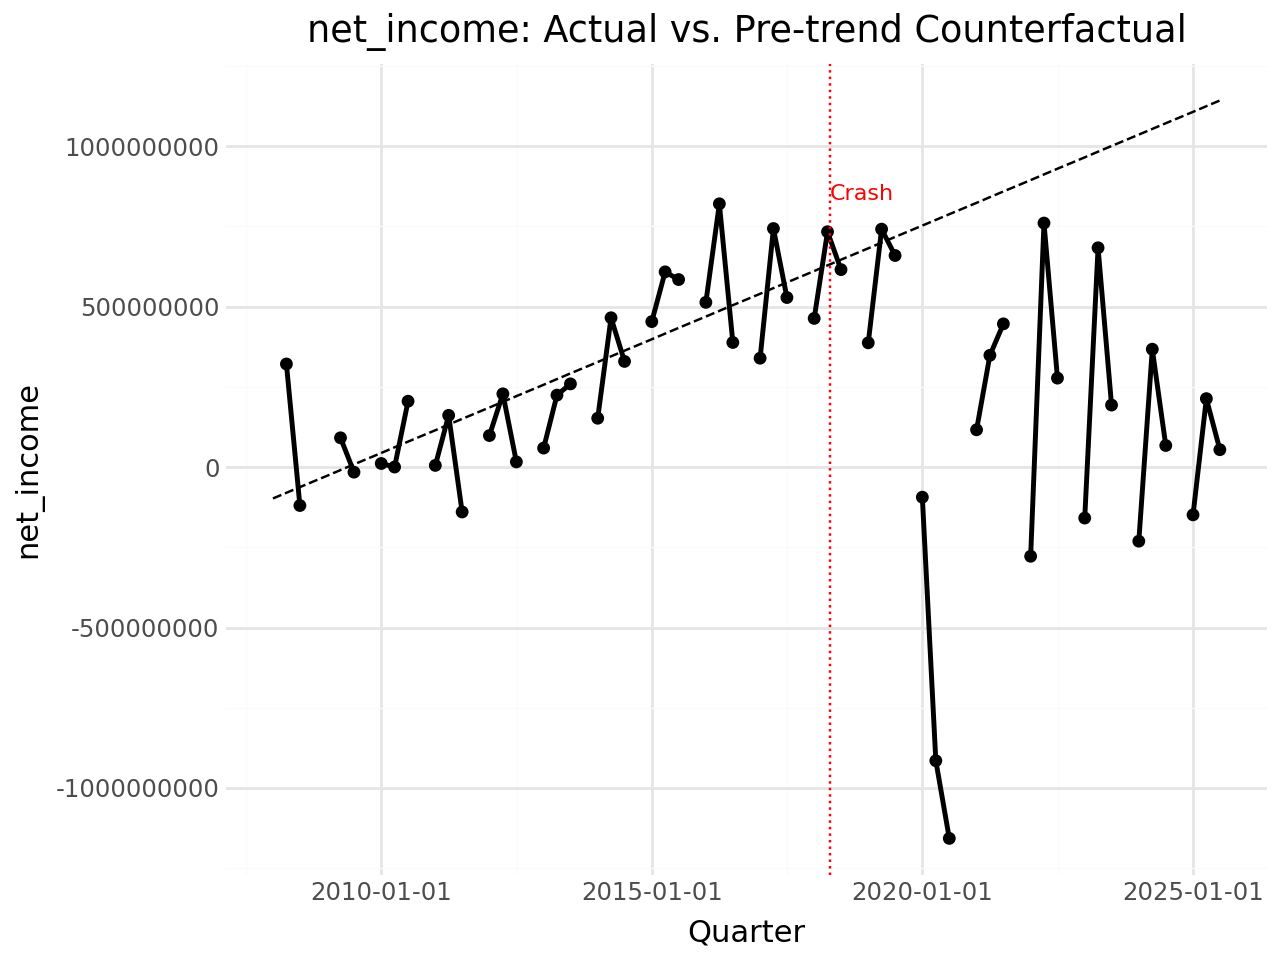

/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 19 rows containing missing values.


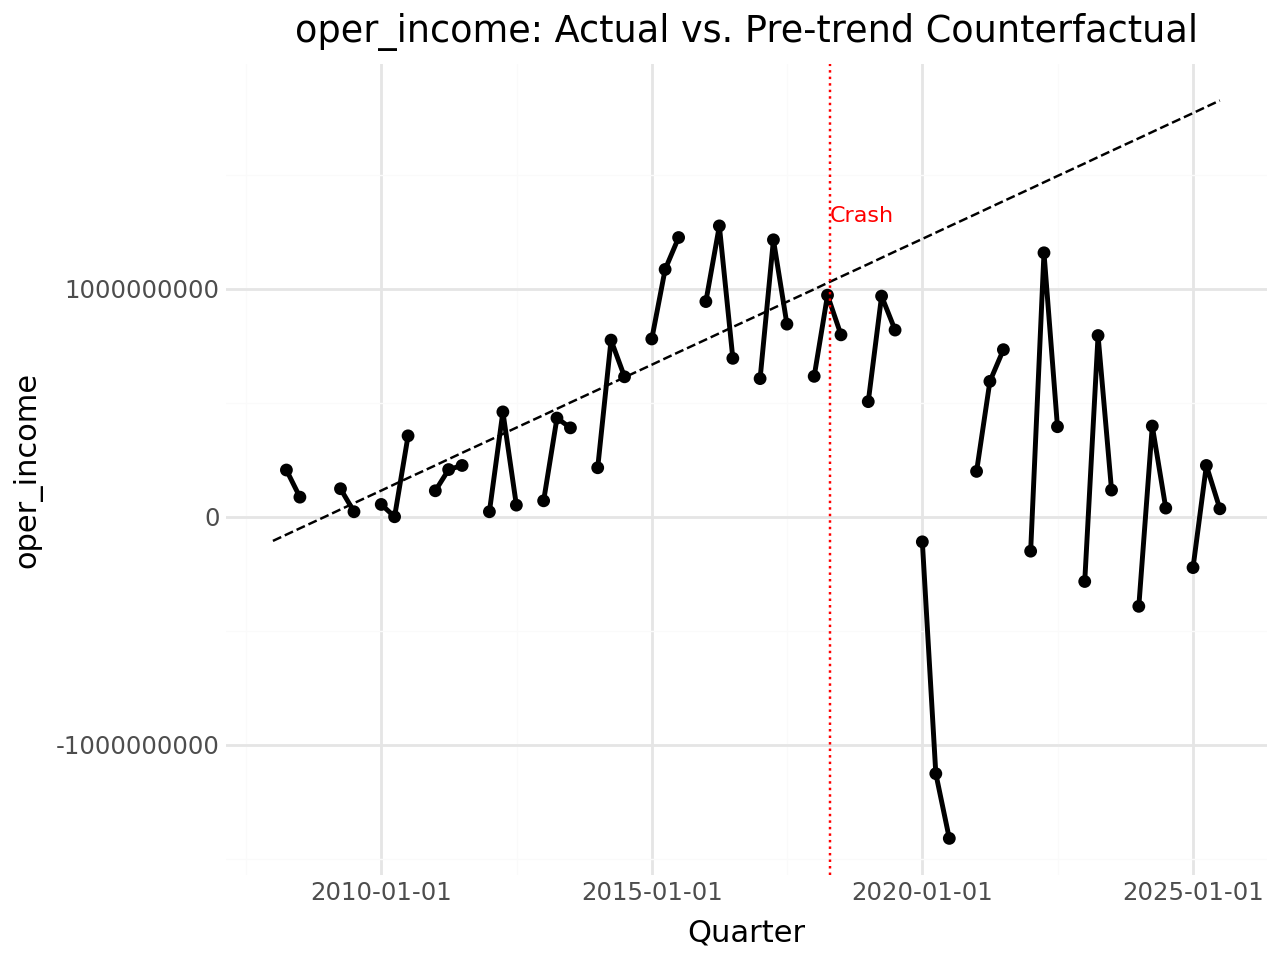

/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 19 rows containing missing values.


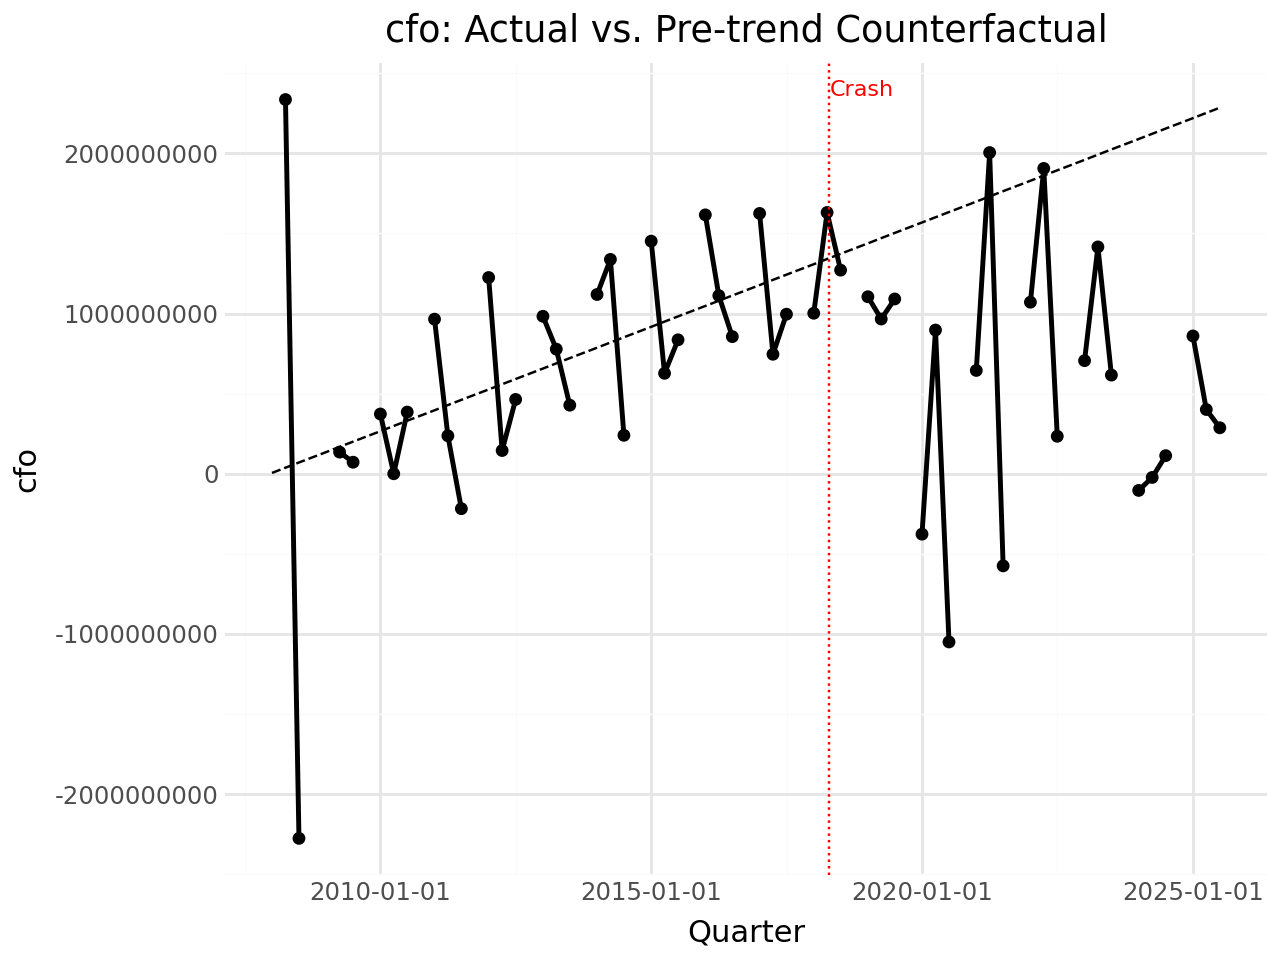

/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 49 rows containing missing values.
/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 55 rows containing missing values.


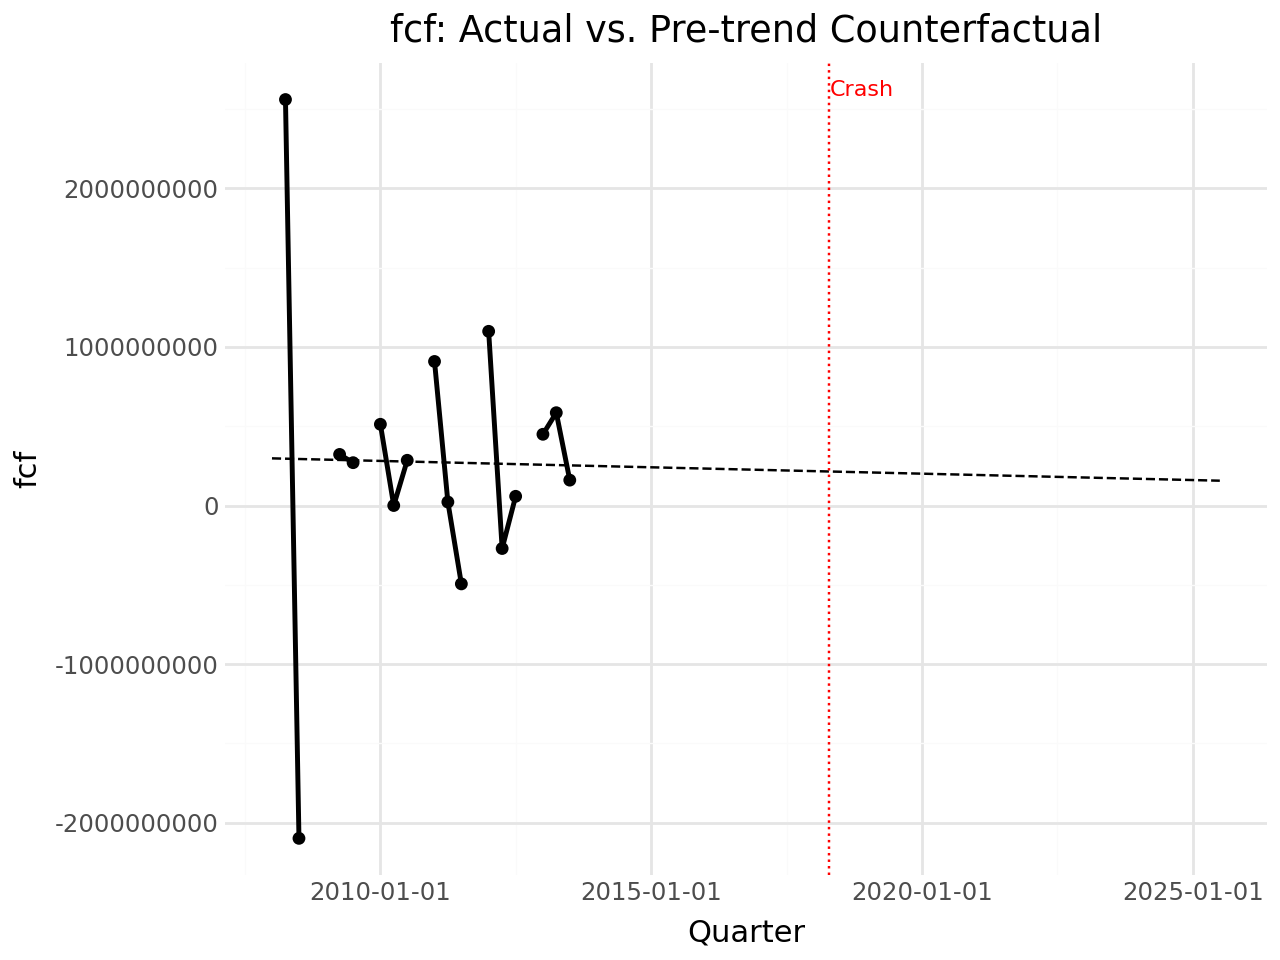

In [9]:
import numpy as np
import pandas as pd
import polars as pl
from plotnine import *


def fundamentals_event_impact_simple(
    df_quarterly: pd.DataFrame,
    event_date: str | pd.Timestamp,
    metrics=("revenue", "net_income", "oper_income", "cfo", "fcf"),
    post_horiz_quarters=8,
    min_pre_points=6,
):
    """
    Analyze how financial fundamentals changed after a crash.
    Fits a simple pre-event linear trend per metric, predicts post-event values,
    and shows actual vs. counterfactual with a crash marker.

    Parameters
    ----------
    df_quarterly : pd.DataFrame
        Must have 'period_end' (datetime) and the metric columns.
    event_date : str | pd.Timestamp
        Date of the crash/incident (e.g., '2018-04-17').
    metrics : tuple[str]
        Columns to analyze.
    post_horiz_quarters : int
        Number of post-event quarters to report (None = all available).
    min_pre_points : int
        Minimum number of pre-event data points to fit a trend.

    Returns
    -------
    impact_pl : polars.DataFrame
        Tidy table of actual, predicted, and delta for post-event quarters.
    plots : dict[str, plotnine.ggplot]
        Overlay plots with vertical crash marker.
    """
    event_date = pd.Timestamp(event_date)
    df = df_quarterly.copy().sort_values("period_end")
    df["quarter_start"] = (
        pd.to_datetime(df["period_end"]).dt.to_period("Q").dt.start_time
    )
    df = df.drop_duplicates("quarter_start").reset_index(drop=True)
    df["q_idx"] = np.arange(len(df))

    pre = df[df["quarter_start"] < event_date].copy()
    post = df[df["quarter_start"] >= event_date].copy()

    rows = []
    plots = {}

    for m in metrics:
        if m not in df.columns:
            continue
        pre_m = pre[["q_idx", m]].dropna()
        if len(pre_m) < min_pre_points:
            continue

        # Fit linear trend on pre-event data
        x = pre_m["q_idx"].values
        y = pre_m[m].values
        b1, b0 = np.polyfit(x, y, 1)

        # Predict values for all quarters
        df[f"{m}_pred"] = b0 + b1 * df["q_idx"]

        # Collect post-event data
        post_h = post.copy()
        if post_horiz_quarters is not None:
            post_h = post_h.iloc[:post_horiz_quarters].copy()
        post_h[f"{m}_pred"] = b0 + b1 * post_h["q_idx"]
        post_h[f"{m}_delta"] = post_h[m] - post_h[f"{m}_pred"]

        for _, r in post_h.iterrows():
            rows.append(
                {
                    "metric": m,
                    "quarter_start": r["quarter_start"],
                    "actual": None if pd.isna(r[m]) else float(r[m]),
                    "predicted": None
                    if pd.isna(r[f"{m}_pred"])
                    else float(r[f"{m}_pred"]),
                    "delta": None
                    if pd.isna(r[f"{m}_delta"])
                    else float(r[f"{m}_delta"]),
                }
            )

        # Plot with event marker
        p = (
            ggplot(df, aes(x="quarter_start"))
            + geom_line(aes(y=m), size=1.0)
            + geom_point(aes(y=m), size=1.6)
            + geom_line(aes(y=f"{m}_pred"), linetype="dashed")
            + geom_vline(xintercept=event_date, color="red", linetype="dotted")
            + annotate(
                "text",
                x=event_date,
                y=df[m].max(),
                label="Crash",
                color="red",
                ha="left",
                va="bottom",
                size=8,
            )
            + labs(title=f"{m}: Actual vs. Pre-trend Counterfactual", x="Quarter", y=m)
            + theme_minimal()
        )
        plots[m] = p

    impact_pl = (
        pl.from_pandas(pd.DataFrame(rows)).sort(["metric", "quarter_start"])
        if rows
        else pl.DataFrame(
            {
                "metric": [],
                "quarter_start": [],
                "actual": [],
                "predicted": [],
                "delta": [],
            }
        )
    )

    return impact_pl, plots


df = pd.read_parquet(
    "/home/jovyan/git/Collect&AnalyzeFinalProject/luv_q.parquet"
)
impact_tbl, figs = fundamentals_event_impact_simple(
    df, "2018-04-17", metrics=("revenue", "net_income", "oper_income", "cfo", "fcf")
)

for v in figs.values():
    display(v)


/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 18 rows containing missing values.


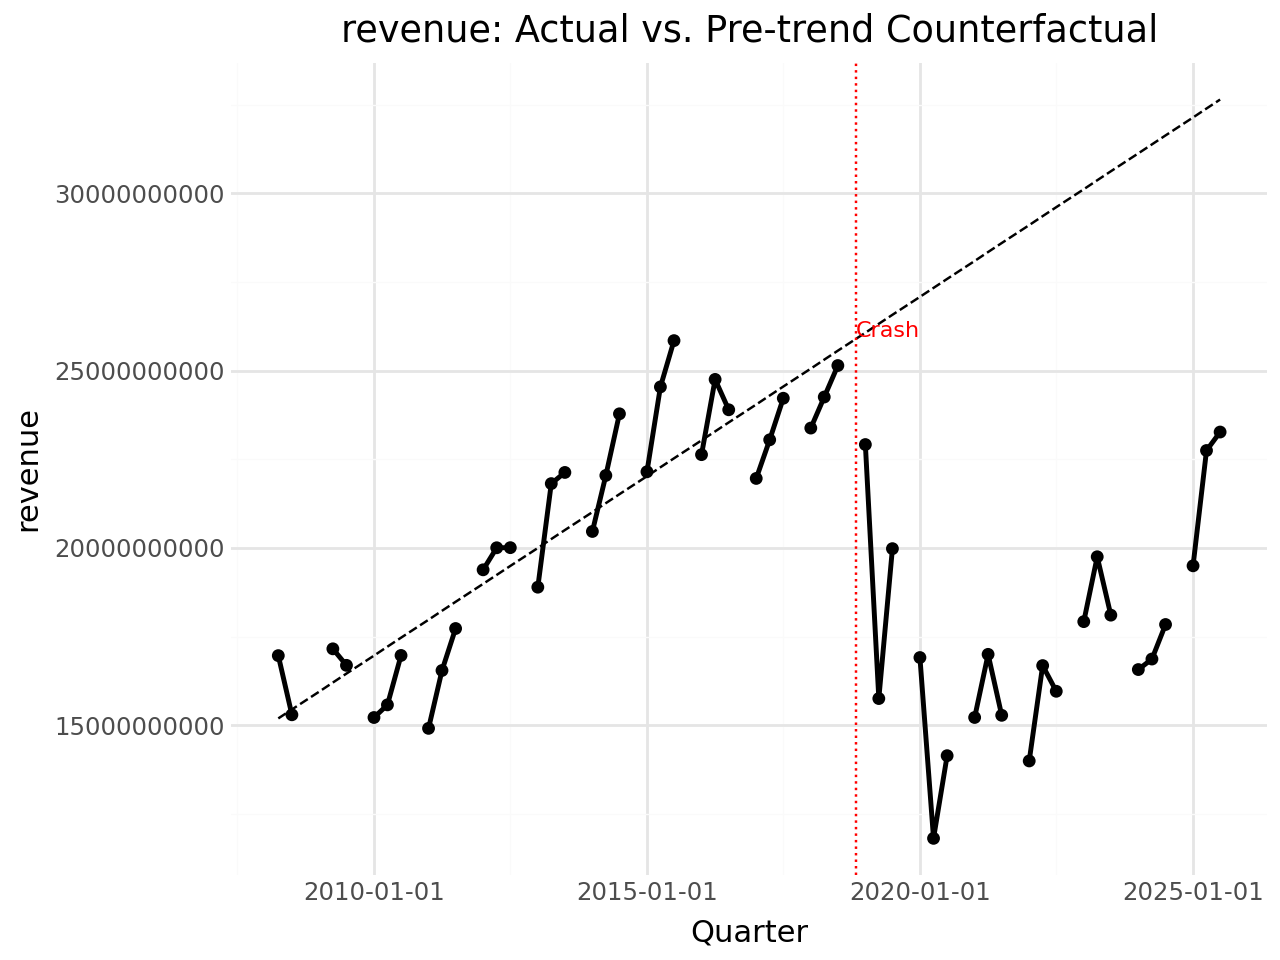

/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 18 rows containing missing values.


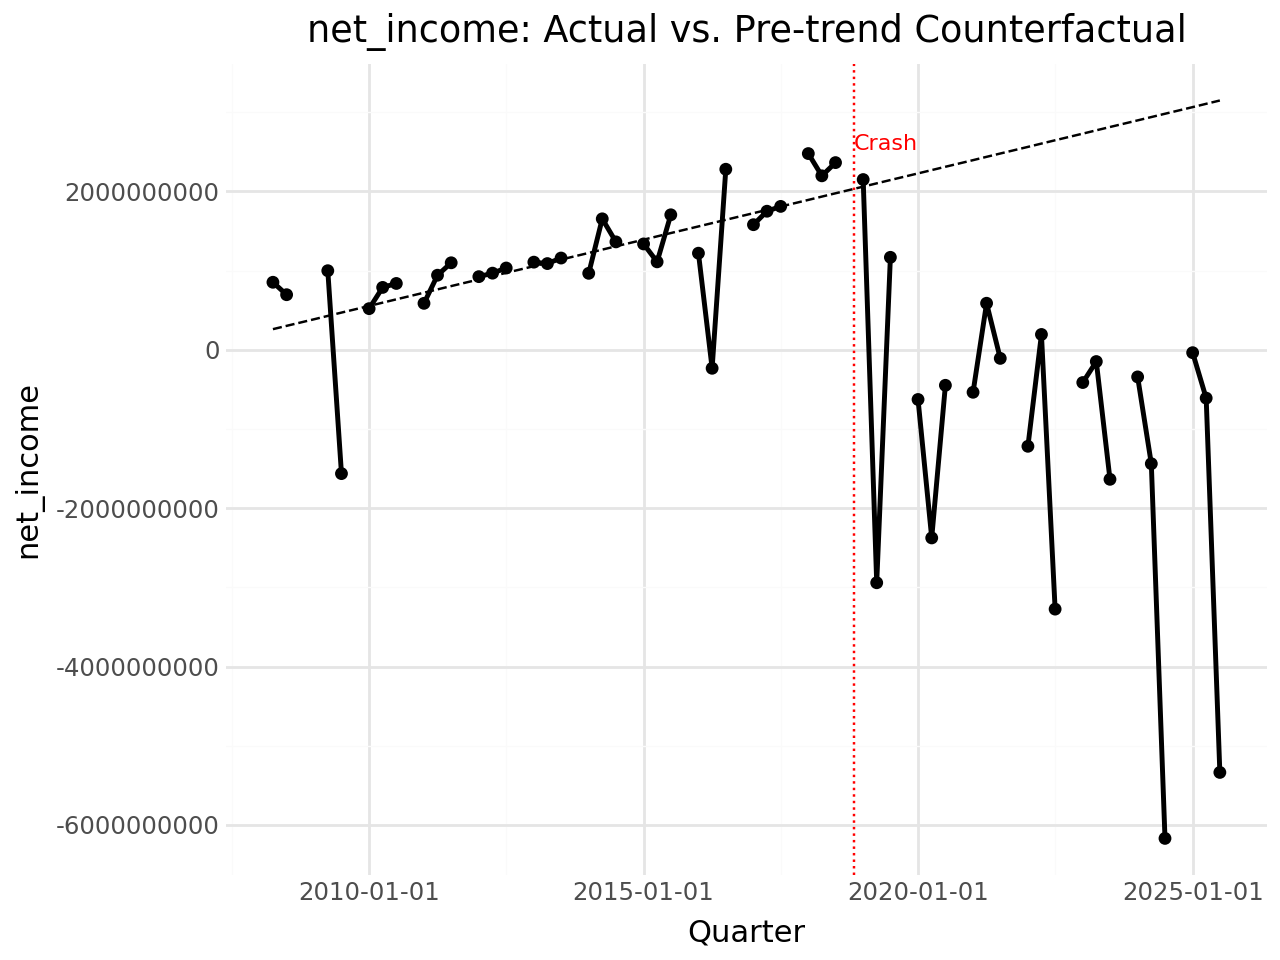

/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 18 rows containing missing values.


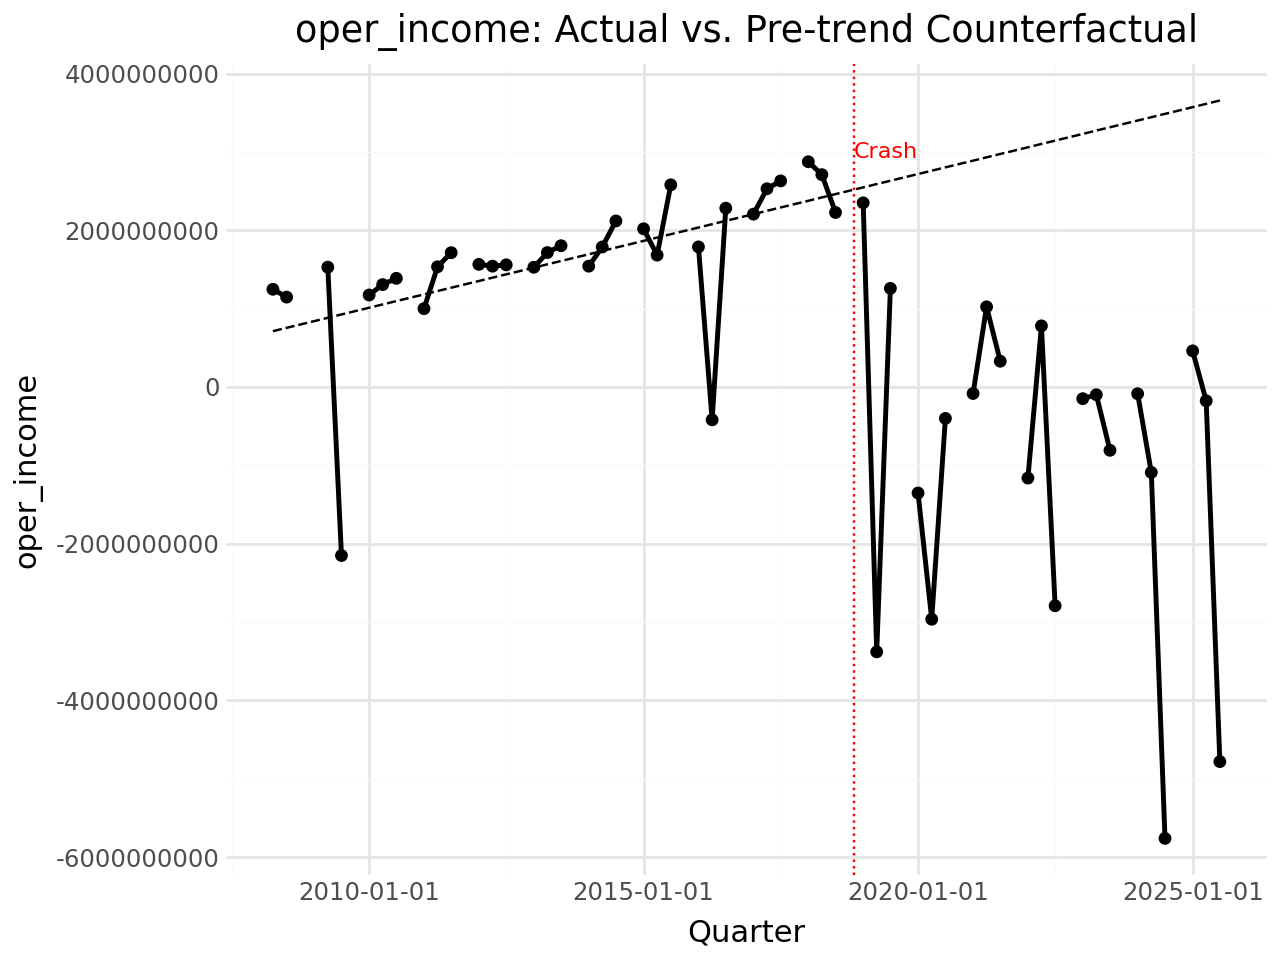

/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 18 rows containing missing values.


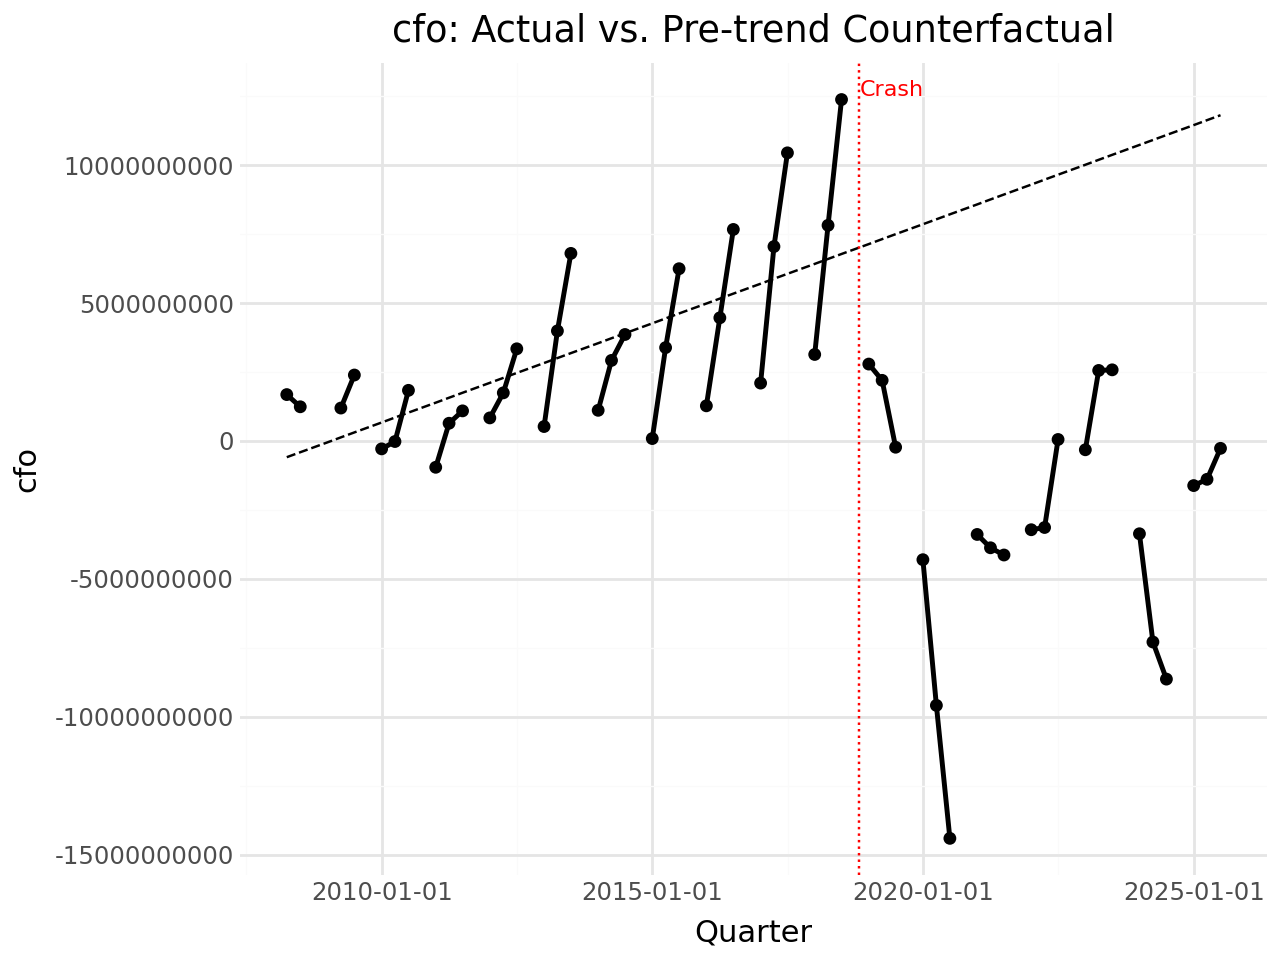

/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 18 rows containing missing values.


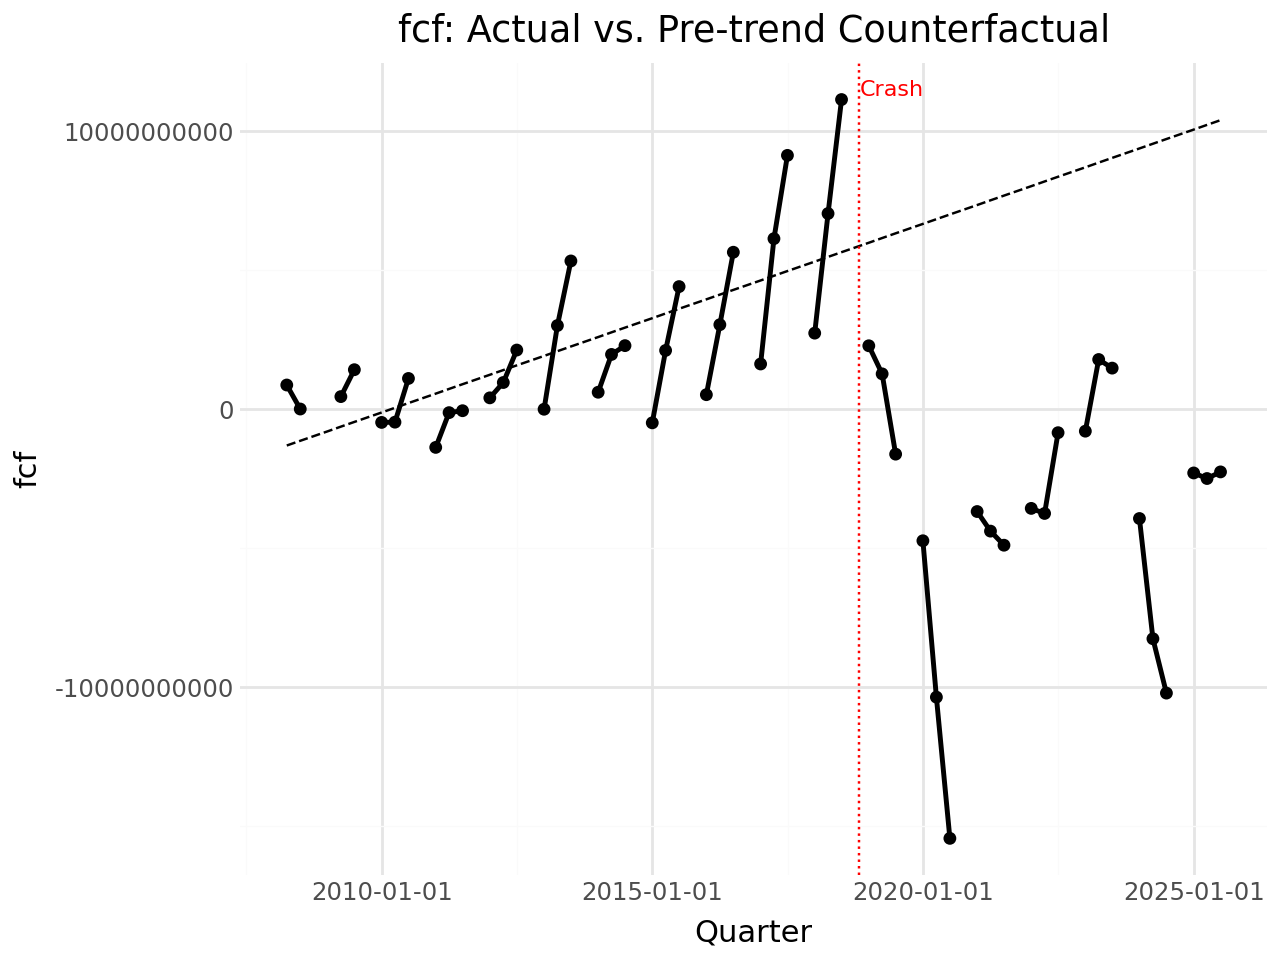

In [ ]:
df = pd.read_parquet(
    "/home/jovyan/Documents/10_fall2025/courses/MGTA452/project/data/financials/ba_q.parquet"
)
impact_tbl, figs = fundamentals_event_impact_simple(
    df, "2018-10-29", metrics=("revenue", "net_income", "oper_income", "cfo", "fcf")
)

for v in figs.values():
    display(v)


In [ ]:
# import requests, os, glob, json

# TARGET_COLS = [
#     "ticker",
#     "period_end",
#     "frequency",
#     "revenue",
#     "oper_income",
#     "net_income",
#     "interest_expense",
#     "total_assets",
#     "total_liabilities",
#     "long_term_debt",
#     "short_term_debt",
#     "cash_and_equiv",
#     "cfo",
#     "capex",
#     "fcf",
#     "net_debt",
#     "source",
# ]

# ESEF_ENTITY = {
#     "EADSY": "Airbus SE",
#     "AF.PA": "Air France-KLM",
#     "LHA.DE": "Deutsche Lufthansa AG",
# }

# # IFRS concept -> target column
# IFRS_MAP = {
#     "ifrs-full:Revenue": "revenue",
#     "ifrs-full:OperatingProfitLoss": "oper_income",
#     "ifrs-full:ProfitLoss": "net_income",
#     "ifrs-full:FinanceCosts": "interest_expense",
#     "ifrs-full:Assets": "total_assets",
#     "ifrs-full:Liabilities": "total_liabilities",
#     "ifrs-full:CashAndCashEquivalents": "cash_and_equiv",
#     "ifrs-full:NoncurrentBorrowings": "long_term_debt",
#     "ifrs-full:CurrentBorrowings": "short_term_debt",
#     "ifrs-full:NetCashFlowsFromUsedInOperatingActivities": "cfo",
#     "ifrs-full:CashFlowsFromUsedInOperatingActivities": "cfo",
#     "ifrs-full:PurchaseOfPropertyPlantAndEquipment": "capex",
#     "ifrs-full:AcquisitionsOfPropertyPlantAndEquipmentClassifiedAsInvestingActivities": "capex",
# }

# ENTITY_ID = {
#     "Airbus SE": "MINO79WLOO247M1IL051",
#     "Air France-KLM": "969500AQW31GYO8JZD66",
#     "Deutsche Lufthansa AG": "529900PH63HYJ86ASW55",
# }


# BASE = "https://filings.xbrl.org"


# def _download_financials(ticker: str) -> None:
#     entity_id = ENTITY_ID[ESEF_ENTITY[ticker]]
#     r = requests.get(
#         f"https://filings.xbrl.org/api/filings?filter[entity.identifier]={entity_id}&include=entity&sort=-processed&page[size]=50",
#         headers=UA,
#         timeout=30,
#     )
#     j = r.json()
#     failed_counter = 0
#     if r.ok:
#         data = j["data"]
#         for i, filing in enumerate(data):
#             if filing["type"] == "filing":
#                 json_url = filing["attributes"]["json_url"]
#                 with requests.get(BASE + json_url, stream=True) as r:
#                     if r.ok:
#                         f_name = f"filing_json_{i}.json"
#                         with open(
#                             os.path.join(ROOT, f"{ticker}", f_name),
#                             "wb",
#                         ) as f:
#                             for chunk in r.iter_content(chunk_size=8192):
#                                 f.write(chunk)
#                     else:
#                         failed_counter += 1
#             else:
#                 failed_counter += 1
#         print(f"download failed count: {failed_counter}")


# def _parse_df(ticker: str, files: list[str]):
#     rows = []
#     for file in files:
#         with open(file) as f:
#             j = json.load(f)

#         facts = j.get("facts", {})
#         if not facts:
#             continue

#         for k, v in facts.items():
#             concept = v.get("dimensions", {}).get("concept")
#             if concept not in IFRS_MAP:
#                 continue

#             period = v["dimensions"].get("period")
#             if "/" in period:
#                 # duration type period
#                 period_end = period.split("/")[-1]
#             else:
#                 period_end = period

#             rows.append(
#                 {
#                     "concept": concept,
#                     "period_end": period_end[:10],  # trim to date
#                     "value": v.get("value"),
#                 }
#             )

#     if not rows:
#         return pd.DataFrame()

#     df = pd.DataFrame(rows)
#     # Map to target column names
#     df["metric"] = df["concept"].map(IFRS_MAP)
#     df = df.drop(columns="concept")

#     # Pivot to have one row per period_end
#     out = df.pivot_table(
#         index="period_end", columns="metric", values="value", aggfunc="first"
#     ).reset_index()

#     # optional: compute FCF and net_debt if available
#     if "cfo" in out and "capex" in out:
#         out["fcf"] = out["cfo"] - out["capex"]
#     if "long_term_debt" in out or "short_term_debt" in out:
#         out["net_debt"] = (
#             out.get("long_term_debt", 0)
#             + out.get("short_term_debt", 0)
#             - out.get("cash_and_equiv", 0)
#         )
#     out["ticker"] = ticker

#     return out


# def get_eu_financials(ticker: str) -> pd.DataFrame | None:
#     sub_path = os.path.join(ROOT, ticker)
#     if not os.path.isdir(sub_path):
#         os.makedirs(sub_path)
#     files = glob.glob(os.path.join(sub_path, "*.json"))
#     if len(files) == 0:
#         try:
#             print(f"downlading files for {ticker}....")
#             _download_financials(ticker)
#         except Exception as e:
#             print(f"error raised: {e}")
#         files = glob.glob(os.path.join(sub_path, "*.json"))

#     df = _parse_df(ticker, files)
#     return df


# df = get_eu_financials("LHA.DE")
# df